In [65]:
import os
import sys
import json
import glob
import random
from random import shuffle
import time
import re
import math
import collections
from tqdm import tqdm
from config import EPOCH, EXPERIMENT
from logger import logger
import mlflow.tensorflow
from mlflow_utils import log_mlflow

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn import model_selection as sk_model_selection
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical

#from tensorflow.python.ops.numpy_ops import np_config

In [3]:
run_params = {'epoch': EPOCH, 'experiment': EXPERIMENT}
EPOCH = run_params.get('epoch', 40)

In [4]:
UNZIP_DATA = False
PROCESS_DATA = True
LOAD_DATA = False
data_dir = "./Data"
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
excluded_images = [109, 123, 709] # Bad images

In [5]:
%%capture
if (UNZIP_DATA):
    !unzip "Data/rsna-miccai-brain-tumor-radiogenomic-classification.zip" -d "Data"

In [157]:
if (PROCESS_DATA):
    train_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv" ))
    train_df = train_df[~train_df.BraTS21ID.isin(excluded_images)]
    test_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
sample_submission = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

In [158]:
def load_image(path, size = 224):
    dicom_file = pydicom.read_file(path)
    dicom_pix = dicom_file.pixel_array
    if np.max(dicom_pix) != 0:
        dicom_pix = dicom_pix / np.max(data)
    dicom_pix = (dicom_pix * 255).astype(np.uint8)
    return cv2.resize(dicom_pix, (size, size))

In [159]:
def get_all_image_paths(brats21id, img_type, folder='train'): 
    if (img_type in mri_types):
        patient_path = os.path.join(data_dir, folder, str(brats21id).zfill(5))
        paths = sorted(glob.glob(os.path.join(patient_path, img_type, "*")),key=lambda x: int(x[:-4].split("-")[-1]))
        return np.array(paths[0:len(paths):1])
    return None

def get_all_images(brats21id, img_type, folder='train', size=225):
    return [load_image(path, size) for path in get_all_image_paths(brats21id, img_type, folder)]



In [160]:
def get_all_data_for_train(train_df, img_type, img_size=32):    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), img_type, 'train', img_size)
        label = x['MGMT_value']
        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)



In [161]:
def get_all_data_for_test(test_df, img_type, img_size=32):
    X = []
    test_ids = []
    for i in tqdm(test_df.index):
        x = test_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), img_type, 'test', img_size)
        X += images
        test_ids += [int(x['BraTS21ID'])] * len(images)

    return np.array(X), np.array(test_ids)

In [162]:
if (PROCESS_DATA):
    X, y, trainidt = get_all_data_for_train(train_df, 'T1wCE')
    X_test, testidt = get_all_data_for_test(test_df, 'T1wCE')
    X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = sk_model_selection.train_test_split(X, y, trainidt, test_size=0.2, random_state=42)

100%|███████████████████████████████████████████| 87/87 [00:38<00:00,  2.28it/s]


In [163]:
if (PROCESS_DATA):
    np.save("x_train_data.npy", X_train)
    np.save("x_valid_data.npy", X_valid)
    np.save("y_train_data.npy", y_train)
    np.save("y_valid_data.npy",  y_valid)
elif (LOAD_DATA): 
    X_train = np.load("x_train_data.npy")
    X_valid = np.load("x_valid_data.npy")
    y_train = np.load("y_train_data.npy")
    y_valid = np.load("y_valid_data.npy")

In [164]:
#https://www.tensorflow.org/api_docs/python/tf/expand_dims
X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)

In [165]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

print(f"X_train data: Rows={X_train.shape[0]}, Columns={X_train.shape[1]}, Type={type(X_train)}")
print(f"X_valid data: Rows={X_valid.shape[0]}, Columns={X_valid.shape[1]}, Type={type(X_valid)}")
print(f"y_train data: Rows={y_train.shape[0]}, Columns={y_train.shape[1]}, Type={type(y_train)}")
print(f"y_valid data: Rows={y_valid.shape[0]}, Columns={y_valid.shape[1]}, Type={type(y_valid)}")

X_train data: Rows=41019, Columns=32, Type=<class 'tensorflow.python.framework.ops.EagerTensor'>
X_valid data: Rows=10255, Columns=32, Type=<class 'tensorflow.python.framework.ops.EagerTensor'>
y_train data: Rows=41019, Columns=2, Type=<class 'numpy.ndarray'>
y_valid data: Rows=10255, Columns=2, Type=<class 'numpy.ndarray'>


## Models

In [166]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="roc_auc", mode='max', patience=3)
roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')
checkpoint_filepath = 'models/ls/best_models'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="auc",
    mode="max",
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)

In [177]:
def eval_model(model, model_name):
    y_pred = model.predict(X_valid)
    pred = np.argmax(y_pred, axis=1)
    res = pd.DataFrame(trainidt_valid)
    res[1] = pred
    res.columns = ["BraTS21ID", "MGMT_value"]
    result = res.groupby("BraTS21ID", as_index=False).mean()
    result = result.merge(train_df, on="BraTS21ID")
    auc = roc_auc_score(result.MGMT_value_y, result.MGMT_value_x,)
    print(f"Validation AUC={auc}")
    log_mlflow(run_params=run_params, model=model1, model_name=model_name, y_true=valid, y_pred=pred)

In [168]:
def get_model1(name='model1'):
    np.random.seed(0)
    random.seed(42)
    tf.random.set_seed(42)

    inputs = keras.Input(shape=X_train.shape[1:])

    h = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

    h = layers.Conv2D(64, kernel_size=(4, 4), activation="relu", name="Conv_1")(h)
    h = layers.MaxPool2D(pool_size=(2, 2))(h)

    h = layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)
    h = layers.MaxPool2D(pool_size=(1, 1))(h)

    h = layers.Dropout(0.1)(h)

    h = layers.Flatten()(h)
    h = layers.Dense(32, activation="relu")(h)

    output = keras.layers.Dense(2, activation="softmax")(h)

    model = keras.Model(inputs, output, name=name)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=[roc_auc])
    
    return model

In [169]:
keras.backend.clear_session()
model1 = get_model1()
model1.summary()
model1.fit(x=X_train, y = y_train, batch_size=64, epochs=40, 
                        callbacks=[model_checkpoint_cb, early_stopping_cb],
                        validation_data=(X_valid, y_valid))

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 29, 29, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 13, 13, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0    

Epoch 18/40
641/641 [==============================] - 19s 30ms/step - loss: 0.2526 - roc_auc: 0.9480 - val_loss: 0.3412 - val_roc_auc: 0.9205
[08/Dec/2021 07:23:04] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 07:23:04] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,val_loss,val_roc_auc
Epoch 19/40
641/641 [==============================] - 20s 31ms/step - loss: 0.2474 - roc_auc: 0.9496 - val_loss: 0.3562 - val_roc_auc: 0.9187
[08/Dec/2021 07:23:24] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 07:23:24] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,val_loss,val_roc_auc
Epoch 20/40
641/641 [==============================] - 21s 32ms/step - loss: 0.2433 - roc_auc: 0.9509 - val_loss: 0.3489 - val_roc_auc: 0.9200
[08/Dec/2021 07:23:44] WARNING - Can save best model only with auc available, ski

641/641 [==============================] - 19s 29ms/step - loss: 0.2158 - roc_auc: 0.9578 - val_loss: 0.3779 - val_roc_auc: 0.9272
[08/Dec/2021 07:30:18] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 07:30:18] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,val_loss,val_roc_auc
Epoch 40/40
641/641 [==============================] - 24s 38ms/step - loss: 0.2119 - roc_auc: 0.9589 - val_loss: 0.3773 - val_roc_auc: 0.9257
[08/Dec/2021 07:30:42] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 07:30:42] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,val_loss,val_roc_auc


Validation AUC=0.9867982156492384
[08/Dec/2021 07:40:46] INFO - AUC: 0.815 | Recall: 0.693 | Precision: 0.910 | F1: 0.787


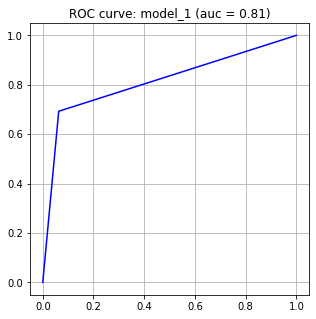

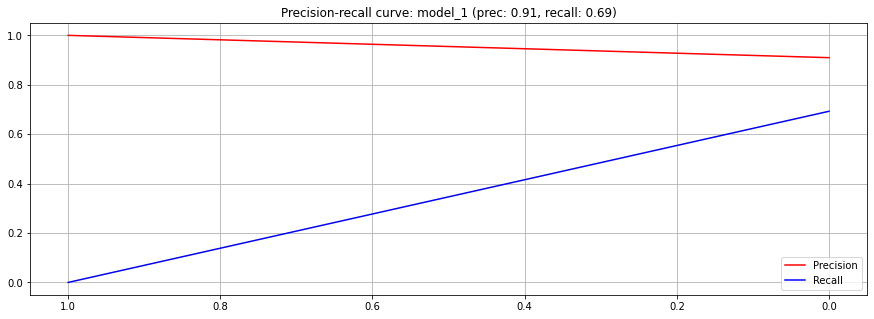

In [179]:
eval_model(model1, "model_1")

In [184]:
def get_model2(name='model2'):
    
    inputs_model = keras.Input(shape=X_train.shape[1:])
        
    input_dim = (32, 32, 1)
    input_tensor = Input(input_dim, name='input2d')
    efnet = DenseNet121(weights=None, include_top = False, input_shape=(32, 32, 3))
    mapping3feat = Conv2D(3, (3, 3), padding='same', use_bias=False)(input_tensor)
    
    output = efnet(mapping3feat)
    output = GlobalAveragePooling2D()(output)
    output = Dense(2, activation='sigmoid')(output)
    
    model = Model(input_tensor, output)
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=Adam(learning_rate=1e-3),
        metrics=[roc_auc, tf.keras.metrics.BinaryAccuracy(name='bacc')],)
    
    
    return model

In [185]:
keras.backend.clear_session()
model2 = get_model2() 
model2.summary()
checkpoint_cb = keras.callbacks.ModelCheckpoint("model2.h5", monitor='val_auc', mode='max', save_best_only=True)
model2.fit(x=X_train, y = y_train, batch_size=64, epochs=5,
           validation_data=(X_valid, y_valid), 
           callbacks=[model_checkpoint_cb, early_stopping_cb])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input2d (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 3)         27        
_________________________________________________________________
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 7,039,581
Trainable params: 6,955,933
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/5
641/641 [==============================] - 247s 376ms/step - loss: 0.6992 - roc_auc: 0.5473 - bacc: 0.

Validation AUC=0.8267089981111603
[08/Dec/2021 08:03:03] INFO - AUC: 0.634 | Recall: 0.805 | Precision: 0.578 | F1: 0.673


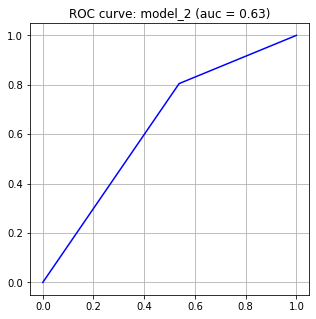

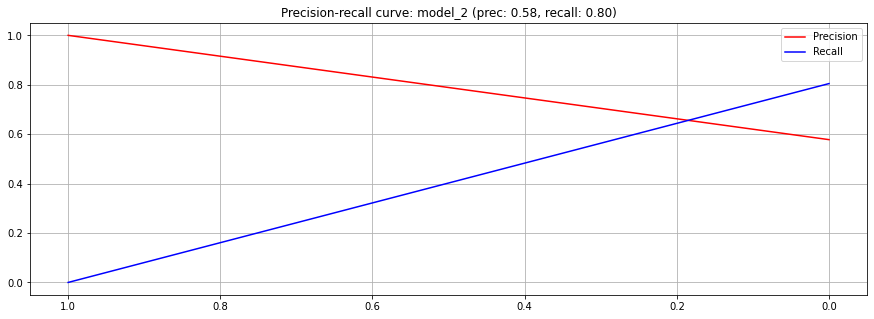

In [188]:
eval_model(model2, "model_2")

In [191]:
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers
#source: https://github.com/milesial/Pytorch-UNet/tree/67bf11b4db4c5f2891bd7e8e7f58bcde8ee2d2db/unet
def get_model3(name="model3"):
    
    inputs_model = keras.Input(shape=X_train.shape[1:])
    input_dim = (32, 32, 1)
    input_tensor = Input(input_dim, name='input2d')
    
    # --- Define model
    conv = lambda x, filters,kernel_size, strides : layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    norm = lambda x : layers.BatchNormalization()(x)
    relu = lambda x : layers.ReLU()(x)
    pool = lambda x : layers.MaxPool2D(pool_size=(3, 3), strides=1, padding='same')(x)
    conv2 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(3,3),strides=(2, 2))))
    
    # --- Define 1x1, 3x3 and 5x5 convs
    conv1 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(1, 1),strides=1)))
    conv3 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(3, 3),strides=1)))
    conv5 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(5, 5),strides=1)))
    mpool = lambda x : relu(norm(pool(x)))
    
    # --- Define projection
    proj = lambda filters, x : layers.Conv2D(
        filters=filters, 
        strides=1, 
        kernel_size=(1, 1),
        padding='same')(x)
    
    tran = lambda x, filters, kernel_size, strides : layers.Conv2DTranspose(
        filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    
    tran_bloc = lambda filters, x : relu(norm(tran(x, filters, kernel_size=(3,3), strides=(2, 2))))
    
    # --- Define concat function
    concat = lambda a, b : layers.Concatenate()([a, b])
    
    # --- Define inception function
    def inception(filters, prev_layer):
        b1 = proj(filters, prev_layer)
        p1 = conv1(filters, prev_layer)
        p2 = conv3(filters, b1)
        p3 = conv5(filters, b1)
        p4 = proj(filters, mpool(prev_layer))
        return layers.Concatenate()([p1,p2,p3,p4])
    
    
    # --- Define contracting layers
    l1 = conv1(32, input_tensor)
    l2 = inception(16, conv2(32, l1))
    l3 = inception(32, conv2(64, l2))
    l4 = inception(64, conv2(128, l3))
    
    # --- Define expanding layers
    l5 = tran_bloc(128, l4)
    l6 = tran_bloc(64, inception(64, conv3(128,concat(l3, l5))))
    l7 = tran_bloc(32, inception(32, conv3(64, concat(l2, l6))))
    l8 = inception(4, l7)
    
    # --- Create logits
    output = layers.Conv2D(filters=2, kernel_size=(3, 3),padding='same')(l8)
    output = GlobalAveragePooling2D()(output)
    output = Dense(2, activation='sigmoid')(output)
    
    # --- Create model
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[roc_auc, tf.keras.metrics.BinaryAccuracy(name='bacc')],)
    
    model.summary()
    
    return model

In [192]:
keras.backend.clear_session()
model3 = get_model3()
model3.fit(x=X_train, y = y_train, batch_size=64, epochs=20,
           validation_data=(X_valid, y_valid), 
           callbacks=[model_checkpoint_cb, early_stopping_cb])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2d (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   64          input2d[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

641/641 [==============================] - 314s 486ms/step - loss: 0.6851 - roc_auc: 0.6646 - bacc: 0.5391 - val_loss: 0.6955 - val_roc_auc: 0.5413 - val_bacc: 0.5246
[08/Dec/2021 08:09:12] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 08:09:12] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,bacc,val_loss,val_roc_auc,val_bacc
Epoch 2/20
641/641 [==============================] - 403s 629ms/step - loss: 0.6383 - roc_auc: 0.6670 - bacc: 0.6044 - val_loss: 0.6384 - val_roc_auc: 0.6875 - val_bacc: 0.6184
[08/Dec/2021 08:15:55] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 08:15:55] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,bacc,val_loss,val_roc_auc,val_bacc
Epoch 3/20
641/641 [==============================] - 367s 572ms/step - loss: 0.5503 - roc_auc: 0.7695 - bacc: 0.6745 - val_loss: 0.5315 

Epoch 20/20
641/641 [==============================] - 302s 470ms/step - loss: 0.2255 - roc_auc: 0.9553 - bacc: 0.8532 - val_loss: 0.3705 - val_roc_auc: 0.9234 - val_bacc: 0.8157
[08/Dec/2021 09:50:12] WARNING - Can save best model only with auc available, skipping.
[08/Dec/2021 09:50:12] WARNING - Early stopping conditioned on metric `auc` which is not available. Available metrics are: loss,roc_auc,bacc,val_loss,val_roc_auc,val_bacc


Validation AUC=0.9909375879114254
[08/Dec/2021 09:50:28] INFO - AUC: 0.810 | Recall: 0.677 | Precision: 0.915 | F1: 0.778


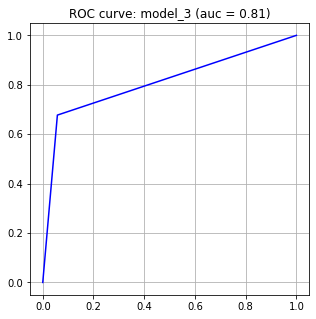

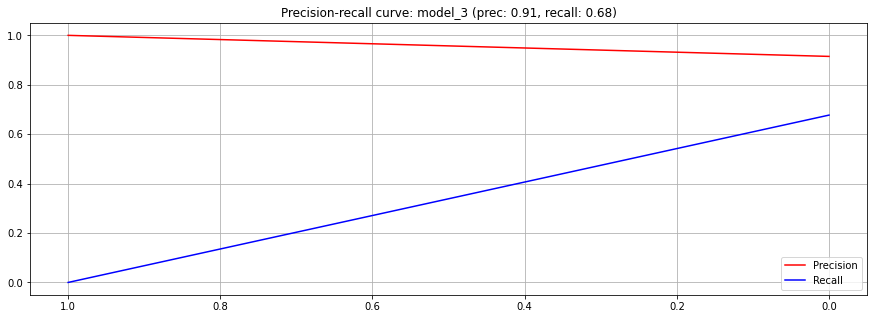

In [193]:
eval_model(model3, "model_3")

## Submission 

In [194]:
SUBMIT = False

In [195]:
if (SUBMIT): 
    res.columns=['BraTS21ID','MGMT_value']
    result = res.groupby('BraTS21ID',as_index=False).mean()
    result['BraTS21ID'] = sample_submission['BraTS21ID']
    result['MGMT_value'] = result['MGMT_value'].apply(lambda x:round(x*10)/10)
    result.to_csv('submission_vincent_dandenault.csv',index=False)